In [1]:
from pcetools import PCE, Uniform, config
import torch
import numpy as np
from torch import sin, pi
import matplotlib.pyplot as plt

In [2]:
distributions = [Uniform(0, 1), Uniform(0, 0.3)]
p = 20
u = PCE(distributions, p)
u.pce_coeffs.requires_grad = True

u_x = u.derivative(0)
u_xx = u_x.derivative(0)
u_t = u.derivative(1)

v = 0.001

optimizer = torch.optim.Adam([u.pce_coeffs], lr=1e-3)

In [3]:
n_pde = 2_000
n_ic = 100
n_bc = 100

epoches = 1000

for epoch in range(epoches):
    X_pde = u.sample(n_pde)
    X_ic = u.sample(n_ic)
    X_bc = u.sample(n_bc)

    def calc_pde_loss(X):
        pde = u_t(X) + u(X) * u_x(X) - v * u_xx(X)
        assert pde.dim() == 1
        return (pde ** 2).sum() / X.size(0)
    
    pde_loss = calc_pde_loss(X_pde)

    def calc_ic_loss(X):
        x, t = X.unbind(-1)
        ic = u(x, 0) - sin(pi*x)
        assert ic.dim() == 1
        return (ic ** 2).sum() / X.size(0)
    
    ic_loss = calc_ic_loss(X_ic)

    def calc_bc_losses(X):
        x, t = X.unbind(-1)
        bc1 = (u(0, t) ** 2).sum() / X.size(0)
        bc2 = (u(1, t) ** 2).sum() / X.size(0)
        assert bc1.dim() == 0
        assert bc2.dim() == 0
        return torch.stack([bc1, bc2], dim=-1)
    
    bc_losses = calc_bc_losses(X_bc)

    losses = torch.stack([
        pde_loss,
        ic_loss,
        *bc_losses
    ], dim=-1)

    assert losses.dim() == 1

    total_loss = ((losses ** 2).sum()) / losses.sum()
    print(f"Epoch {epoch + 1}; Loss: {total_loss.item()}")

    optimizer.zero_grad()
    total_loss.backward()
    optimizer.step()

Epoch 1; Loss: 0.4994956783387212
Epoch 2; Loss: 0.7092071400002556
Epoch 3; Loss: 0.41260662630321254
Epoch 4; Loss: 0.4269342024015301
Epoch 5; Loss: 0.42089361329535313
Epoch 6; Loss: 0.6122234194956688
Epoch 7; Loss: 0.5699594799755939
Epoch 8; Loss: 0.4126001738137262
Epoch 9; Loss: 0.39942452306583953
Epoch 10; Loss: 0.3924285135031365
Epoch 11; Loss: 0.47249461779685675
Epoch 12; Loss: 0.7312865206097612
Epoch 13; Loss: 0.38536742583137706
Epoch 14; Loss: 0.3860234719918476
Epoch 15; Loss: 0.3660101882288486
Epoch 16; Loss: 0.37783292121339734
Epoch 17; Loss: 0.4161644768874455
Epoch 18; Loss: 0.9241338886924579
Epoch 19; Loss: 0.36719426353727036
Epoch 20; Loss: 0.3569884728926297
Epoch 21; Loss: 0.3607000375716422
Epoch 22; Loss: 0.34971895583097123
Epoch 23; Loss: 0.3436997935834392
Epoch 24; Loss: 0.34297824910578545
Epoch 25; Loss: 0.3377301205059672
Epoch 26; Loss: 0.33709514569527926
Epoch 27; Loss: 0.34587504515020645
Epoch 28; Loss: 0.34712503606909817
Epoch 29; Loss: 0

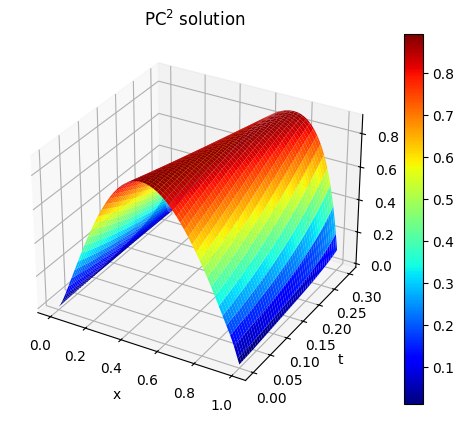

In [4]:
from mpl_toolkits.mplot3d import Axes3D

# Создаем сетку значений x и t
x = np.linspace(0, 1, 100)
t = np.linspace(0, 0.3, 100)
x, t = np.meshgrid(x, t)

x_torch = torch.tensor(x, dtype=config.dtype)
t_torch = torch.tensor(t, dtype=config.dtype)

grid_points = torch.stack([x_torch.flatten(), t_torch.flatten()], dim=1)

def predict(model, inputs):
    with torch.no_grad():
        return model(inputs).reshape(x_torch.shape)

velocity = predict(u, grid_points).numpy()

# Создаем 3D график
fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')

# Плотим поверхность
surf = ax.plot_surface(x, t, velocity, cmap='jet')

# Добавляем цветовую шкалу
fig.colorbar(surf)

# Настраиваем оси
ax.set_xlabel('x')
ax.set_ylabel('t')
ax.set_zlabel('u(x, t)')
ax.set_title('PC$^2$ solution')

plt.show()
